In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
from matplotlib.collections import PatchCollection

In [3]:
def preprocessing(filename="data/value_policy.csv"):
    info = pd.read_csv("data/env_info.csv")
    episodes=info['episodes_num'][0]
    states=info['state_space_dim'][0]
    episodes_step=info['episode_write_step'][0]
    df = pd.read_csv(filename)
    df["State"] = [i%states for i in range(episodes*states//episodes_step)]
    df["Episode"] = [(i//states)*episodes_step for i in range(episodes*states//episodes_step)]
    index = ['Episode', 'State']
    df.set_index(index, inplace=True)
    #df = df.loc[(slice(None),[0,1,2,4,8,16]),:]
    return df

#Extract policy
def extract_policy(df, bird):
    d = df[["left_"+str(bird), "straight_"+str(bird), "right_"+str(bird)]]
    d = d.unstack("State")
    #Softmax
    m = d.mean(axis=1, level=1)
    d = d.subtract(m,axis=0)
    d = d.apply(np.exp)
    s = d.sum(axis=1, level=1)
    d = d.divide(s,axis=0)
    return d

def extract_value(df, bird):
    d = df["value_"+str(bird)]
    d = d.unstack("State")
    return d

<AxesSubplot:xlabel='Episode'>

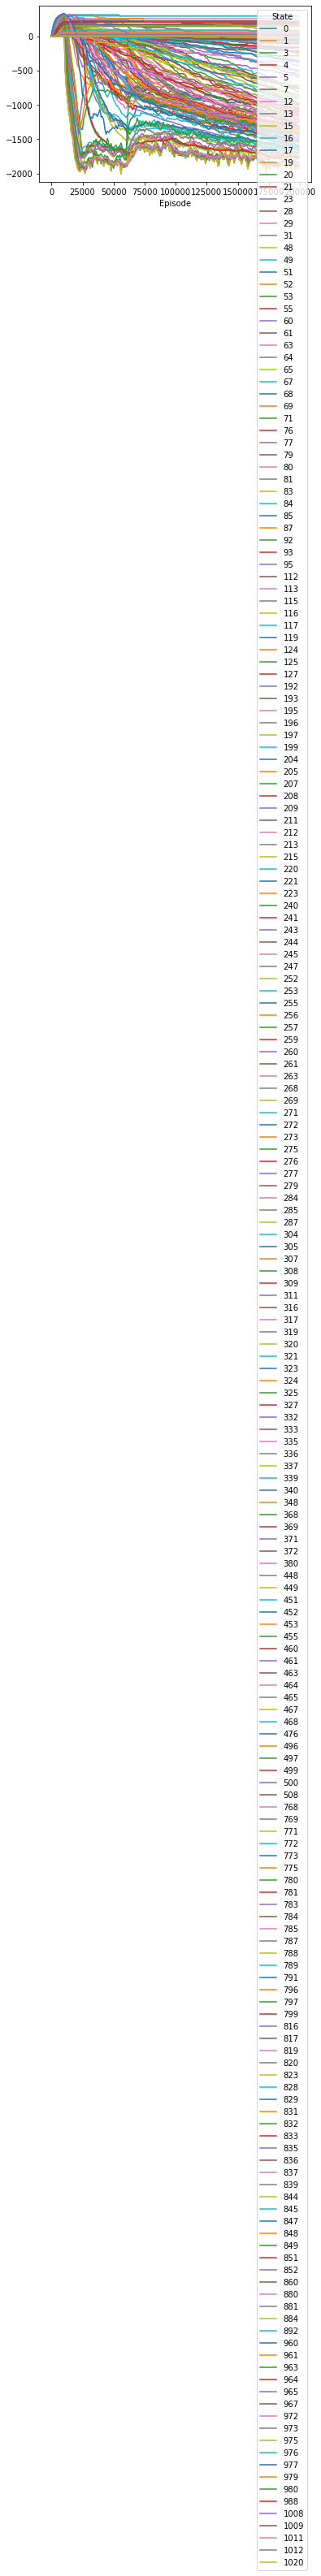

In [4]:
df = preprocessing(filename="data/value_policy.csv")
df_val = extract_value(df,0)
#df_val
df_val.loc[:, (df_val != df_val.iloc[0]).any()].plot(legend=True)
#Can clearly see that we haven't reach convergence for the value func

<AxesSubplot:xlabel='Episode'>

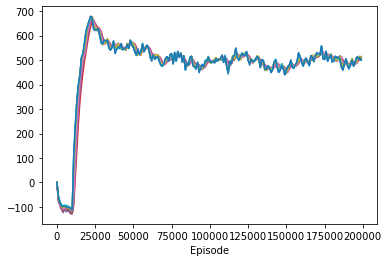

In [5]:
df = preprocessing(filename="data/value_policy.csv")
df_val = extract_value(df,1)
df_val.loc[:, (df_val != df_val.iloc[0]).any()].plot(legend=False)
#This is more convergent for policies

<AxesSubplot:xlabel='Episode'>

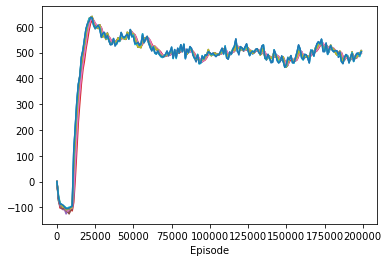

In [6]:
df = preprocessing(filename="data/value_policy.csv")
df_val = extract_value(df,2)
df_val.loc[:, (df_val != df_val.iloc[0]).any()].plot(legend=False)
#This is more convergent for policies

<AxesSubplot:xlabel='Episode'>

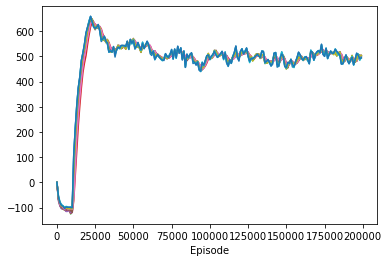

In [7]:
df = preprocessing(filename="data/value_policy.csv")
df_val = extract_value(df,3)
df_val.loc[:, (df_val != df_val.iloc[0]).any()].plot(legend=False)
#This is more convergent for policies

<AxesSubplot:xlabel='Episode'>

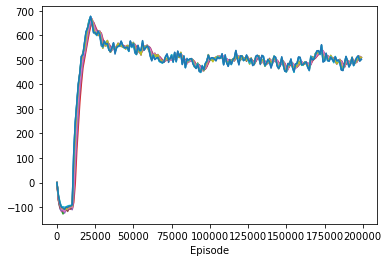

In [8]:
df = preprocessing(filename="data/value_policy.csv")
df_val = extract_value(df,4)
df_val.loc[:, (df_val != df_val.iloc[0]).any()].plot(legend=False)
#This is more convergent for policies

## Diagnostic tools

-30.00001285727039


,episode,bird,sec0,sec1,sec2
0,0,0,0,0,0
1,0,1,0,0,0
2,0,2,0,0,0
3,0,3,0,0,0
4,0,4,0,0,0


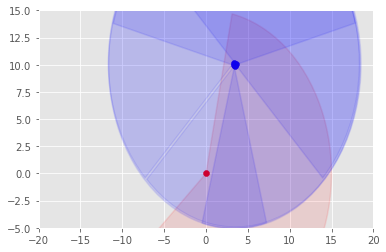

In [20]:
def select_frame(ep,frame=0,birds_num=10):
    df = pd.read_csv("data/pursuer_trajectory.csv")
    df = df[df["Episode"]==ep].iloc[frame]
    
    fig, ax = plt.subplots(1,1)
    patches = []
    
    ax.scatter(df["x"+str(0)],df["y"+str(0)], color="red")
    print(df["alpha"+str(0)]*180/math.pi)
    wedge = mpatches.Wedge((df["x"+str(0)], df["y"+str(0)]), 15, 
                           df["alpha"+str(0)]*180/math.pi - 6*18, df["alpha"+str(0)]*180/math.pi + 6*18, 
                           alpha=0.1, lw=1.5, color="red")
    patches.append(wedge)
    
    for i in range(1,birds_num):
        ax.scatter(df["x"+str(i)],df["y"+str(i)], color="blue")
        wedge = mpatches.Wedge((df["x"+str(i)], df["y"+str(i)]), 15, 
                           df["alpha"+str(i)]*180/math.pi - 135, df["alpha"+str(i)]*180/math.pi + 135, 
                           alpha=0.1, lw=1.5, color="blue")
        patches.append(wedge)
    
        
    collection = PatchCollection(patches, match_original=True)
    ax.add_collection(collection)
    ax.set_xlim(-20,20)
    ax.set_ylim(-5,15)
        
    return ax

ep = 0
fr = 0
bn = 5
select_frame(ep, frame=fr, birds_num=bn)

df = pd.read_csv("data/observations.csv")
df = df[df["episode"]==ep]
df.iloc[fr*bn:(fr+1)*bn]

## Policy animation

In [17]:
def obs_to_state(obs, sec_num=5, state_per_sector=3):
    """
        Transforms a dictionary defining an observation into the index of a state.
        The observation is defined like
        obs = {'none':[0,1], 'evader':[bla], 'pursuer':[bla]}
    """
    state = np.empty([sec_num,1])
    for i in obs['none']:
        state[i] = 0
    for i in obs['foe']:
        state[i] = 1
    for i in obs['brother']:
        state[i] = 2
    for i in obs['both']:
        state[i] = 3
    
    state_num = 0

    for i in range(sec_num):
        state_num+=state[i]*pow(state_per_sector,i)
        
    return int(state_num)

def state_to_color(state, sec_num=5, base=3):
    col = ["white" for i in range(sec_num)]
    state_base = np.empty(sec_num)
    for i in range(0,sec_num):
        state_base[i] = (state//base**i)%base
    
    for i in range(sec_num):
        if state_base[i] == 0:
            col[i] = "white"
        elif state_base[i] == 1:
            col[i] = "red" #Now stands for foe
        elif state_base[i] == 2:
            col[i] = "blue"  #Now stands for brother
        elif state_base[i] == 3:
            col[i] = "purple"
            
    return col

def create_wedge(state, ax, sec_num=5, state_per_sector=3):

    patches = []
    
    # add the vision cone
    sector_angle = 180/(sec_num)
    min_ang = 0
    max_ang = sector_angle
    col = state_to_color(state, sec_num, state_per_sector)
    for i in range(sec_num):
        wedge = mpatches.Wedge((1, 1), 2, min_ang, max_ang, 
                               alpha=0.1, lw=1.5, color=col[i])
        min_ang += sector_angle
        max_ang += sector_angle
        patches.append(wedge)

    x = [2*math.cos(-math.pi/(sec_num)*i)+1 for i in range(1,sec_num)]
    y = [2*math.sin(math.pi/(sec_num)*i)+1 for i in range(1,sec_num)]

    for i in range(sec_num-1):
        ax.plot([1,x[i]],[1,y[i]], color="cornflowerblue", lw=0.3)
    
    t_p = np.array([[0,0], [1/2,math.sqrt(3)/2], [1,0]])*1/2  + np.array([3/4,1/2])
    
    # Simplex outside sectors
    t = mpatches.Polygon(t_p, alpha=0.2, lw=2)
    patches.append(t)
       
    return patches, t_p #, t_coord

In [18]:
def plot_policy_ep(bird, obs, episode=-1, birds_num=2, sec_num=3, state_per_sector=2):
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(10,6))
    state = obs_to_state(obs, sec_num, state_per_sector)
    patches, t_p = create_wedge(state, ax, sec_num, state_per_sector)
    collection = PatchCollection(patches, match_original=True)
    
    plt.axis('equal')
    plt.axis('off')
    
    df = preprocessing(filename="data/value_policy.csv")
    df = extract_policy(df, bird)
    
    if episode == -1:
        df = df.iloc[-1] #Number of episode
    else :
        df = df.loc[episode]
    
    #df.reset_index(drop=True,inplace=True)
    x = (df[("right_"+str(bird),)] - df[("left_"+str(bird),)])/2 + 0.5
    y = df[("straight_"+str(bird),)]*math.sqrt(3)/2
    s_point = t_p[0] + np.array([x[state]/2, y[state]/2])
    ax.scatter(s_point[0], s_point[1])
    ax.add_collection(collection)

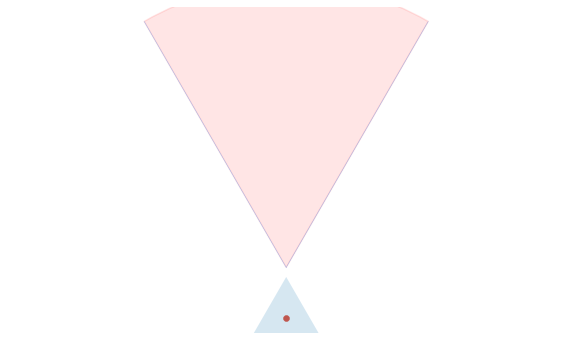

In [19]:
plot_policy_ep(0, {"none":[0,2], "foe":[1], "brother":[], "both":[]}, birds_num=2, sec_num=3, state_per_sector=2)

In [102]:
def animate_policy(bird, obs, birds_num=2, sec_num=3, base=1):
    plt.style.use('ggplot')
    fig, ax = plt.subplots()
    points = ax.scatter([], [], color="darkblue", s=sec_num)

    #patches, tp, t_coord = create_wedge(state)
    state = obs_to_state(obs)
    patches, t_p = create_wedge(state, ax, sec_num, base)

    collection = PatchCollection(patches, match_original=True)
    ax.add_collection(collection)
    plt.axis('equal')
    plt.axis('off')
    t = plt.text(-1,3,"Episode 0")
    t.set_color('red')
    plt.tight_layout()

    #Data preparation
    df = preprocessing(filename="data/value_policy.csv")
    df = extract_policy(df, bird)
    df.reset_index(drop=True,inplace=True)
    x = (df[("right_"+str(bird),)] - df[("left_"+str(bird),)])/2 + 0.5
    y = df[("straight_"+str(bird),)]*math.sqrt(3)/2
    sec_num = len(df)

    x = x[state]
    y = y[state]
    #print(x)

    def animate(i):
        #p = np.empty([6,2])
        s_point = t_p[0] + np.array([x[i]/2, y[i]/2])
        p = [s_point[0], s_point[1]]
        #p[0,:] = [s_point[0], s_point[1]]

        #for j,k in enumerate(sectors[:0:-1]):
            #s_point = t_coord[j] + np.array([x[k][i]/2, y[k][i]/2])
            #p[j+1,:] = [s_point[0][0], s_point[0][1]]

        points.set_offsets(p)
        t.set_text("Episode "+str(i*1000))
        if ((i*1000)//20000)%birds_num == 0:
            t.set_color('red')
        else:
            t.set_color('blue')
        return points,t,

    anim = animation.FuncAnimation(fig, animate, frames=len(x), interval=20, blit=True)
    return anim

KeyError: 'pursuer'

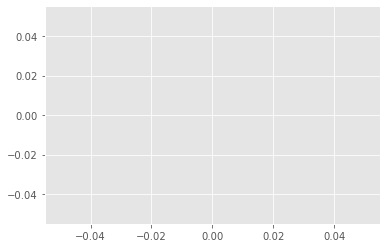

In [27]:
anim_p = animate_policy(1,{'none':[0,1,2], 'evader':[3]},birds_num=2)
HTML(anim_p.to_html5_video())